# GHP Construction with Duration Matching

https://github.com/WongYatChun/Introduction_to_Portfolio_Construction_and_Analysis_with_Python/blob/master/lab_126_GHP_and_Duration_Matching.ipynb

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [2]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [3]:
erk.bond_price(20, 1000, 0.05, 2, 0.04) # here, the discount rate is lower than the coupon rate, so we get a bond price that is at a premium

1136.7773962036904

In [4]:
erk.bond_price(20, 1000, 0.05, 2, 0.06) # here, the discount rate is higher than the coupon rate, so we get a bond price that is at a discount

884.4261401289671

In [5]:
erk.bond_price(20, 1000, 0.05, 2, 0.05) # here, the discount rate is equal to the coupon rate, so we get a bond price that is at par

1000.0000000000023

In [6]:
rates = np.linspace(0.01, 0.10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [7]:
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates] # list comprehension way of implementing a for loop -- this will output a list of prices calculated for each interest rate in 'rates'
prices # as the interest rate increases, the bond price will decrease

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

<Axes: title={'center': 'Price of a 10Y, 5 percent coupon bond with different interest rates'}>

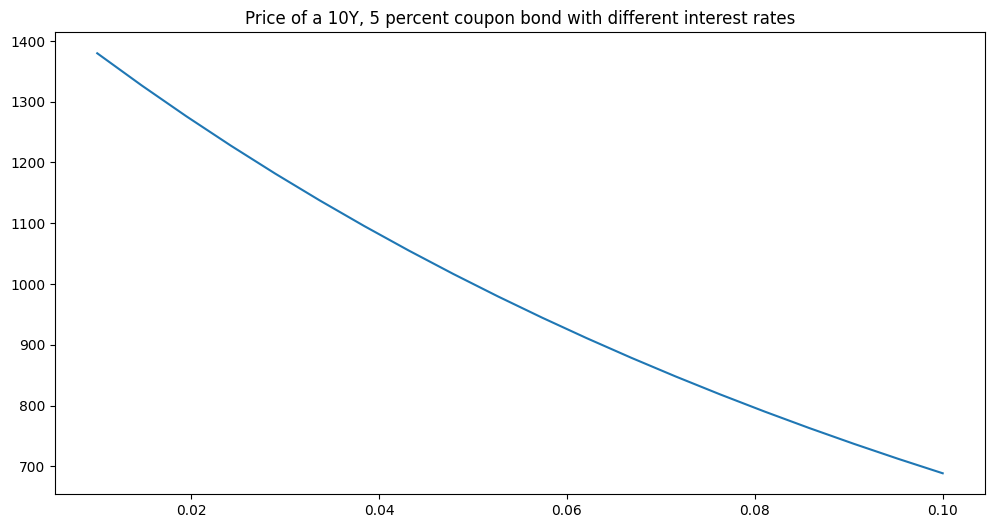

In [10]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of a 10Y, 5 percent coupon bond with different interest rates", legend=False, figsize=(12,6))

In [11]:
cf = erk.bond_cash_flows(3, 1000, .06, 2) # cash flows for a 3Y bond at par 1000, coupon of 6%, paid semi-annually
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [12]:
# since we start getting part of our money back in installments from the first period onwards, what is the effective waiting period to get the money back?
# we will do that by first calculating the discount factors of each of the cash flows

discounts = erk.discount(cf.index, 0.06/2)
discounts

Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
       0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
      dtype='float64')

In [14]:
dcf = discounts*cf # calculating discounted cash flows, i.e. the pv of each of the cash flows from this bond
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [16]:
# obtain a set of weights
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [18]:
# weighted average of all the periods, ie the average period the investor waits to get all the money back
(cf.index*weights).sum()

5.579707187194534

The above is called the Macaulay Duration. For a zero coupon bond, the Macaulay duration is equal to the maturity of the bond. For any non-zero coupon bond, the Macaulay duration will be shorter than the maturity of the bond.

In [19]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)

5.579707187194534

## Duration Matching

In [20]:
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])  # liabilities are two payments of 100000 each, one at 10 years and one at 12 years. These are the cash flows
erk.macaulay_duration(liabilities, 0.04) # assuming discount rate is 4%


10.960799385088393

Now assume we have two types of bonds available. We have a 10 year bond and a 20 year bond. Each of them pays a 5% coupon once a year and has a face value of $1000. What are the durations of these bonds?

In [21]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, 0.05, 1), 0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, 0.05, 1), 0.04)

In [22]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)
```

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:

```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```

In [23]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [27]:
# let us test that this weight in the shorter bond will yield the target duration
p_short = erk.bond_price(10, 1000, .05, 1, 0.04)
p_long = erk.bond_price(20, 1000, .05, 1, 0.04)
a_0 = 130000
"""
explanation for short bond as an example
cash flow for each short bond = short_bond
bond price = p_short
weight of short bond = w_s
amount invested in short bond = a_0*w_s
number of short bonds purchased = a_0*w_s/p_short
total cash flows = above number of short bonds purchased * p_short
"""
dm_assets=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long]) # these are the cash flows of the duration-matched assets portfolio
erk.macaulay_duration(dm_assets, 0.04)

10.960799385088393

The above duration is exactly equal to the duration of the liabilities that we calculated further above. We will update the funding ratio function in erk to allow for the assets to be a series of cash flows.

In [26]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04) # current funding ratio
cfr

0.9998760012192478

In [28]:
lb_assets = a_0*long_bond/p_long
erk.funding_ratio(lb_assets, liabilities, 0.04)

0.9998760012192477

In [29]:
sb_assets = a_0*short_bond/p_short
erk.funding_ratio(sb_assets, liabilities, 0.04)

0.9998760012192477

<Axes: title={'center': 'Change in Funding Ratio with Change in Interest Rates'}>

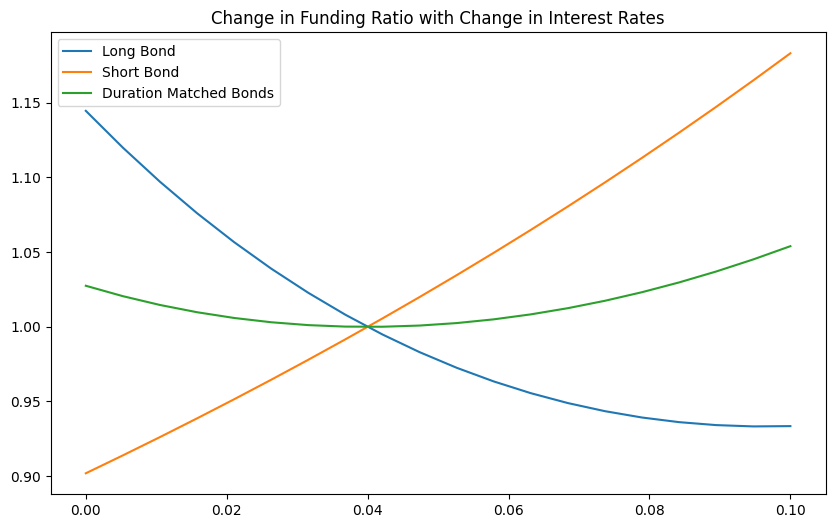

In [30]:
rates = np.linspace(0,0.1, 20)
# model change in funding ratios
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(dm_assets, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio with Change in Interest Rates', figsize=(10,6))